In [1]:
!pip install nltk
!pip install gensim
!pip install tqdm
!pip install bs4
!pip install emoji
!pip install contractions
!pip install wordcloud
!pip install xgboost

In [167]:
import pandas as pd
import numpy as np
import nltk
import emoji
import ast
import contractions
import matplotlib.pyplot as plt
import seaborn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# nltk functions for data cleaning
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize.casual import TweetTokenizer

# Sklearn functions for machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from gensim.models import word2vec
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
tqdm.pandas()

# 1. Data Cleaning

Let's first import the generic tweets, 2019 Canadian election tweets, and the sentiment corpus data into pandas dataframes.  The generic tweets can be imported as regular string data but the election data is formatted as byte strings, therefore the ast module was used to convert the column to it's native byte string format.

In [3]:
generic_raw = pd.read_csv("generic_tweets.txt")
generic = generic_raw.drop(['query'], axis = 1) # Drop the query column since they are all the same value
generic['class'] = generic['class'].replace(4,1) # Replace 4 as positive emotion with 1 to match the election data
generic_text = generic['text'].to_numpy()

elections_raw = pd.read_csv("Canadian_elections_2019.csv", dtype = {'text': bytes})
elections = elections_raw.copy()
elections['sentiment'] = elections['sentiment'].replace({"positive": 1, "negative": 0}) # Replace categorical values with binary labels
elections['text'] = elections['text'].apply(ast.literal_eval) # Convert "text" column to byte strings
elections_text = elections['text'].to_numpy()

corpus_raw = pd.read_csv("corpus.txt", sep = '\t', header = None)
corpus_raw.columns = ['word', 'sentiment']

When performing natural language processing, it's important to define some "stop words" which are common words that typically do not provide additional information towards the problem you are trying to solve.  Removing stop words can reduce the number of features in your machine learning algorithms, decrease the processing time, and improve accuracy.  Here I used nltk's set of english stop words but removed some words such as "no" and "not" because I believe they are relevant to sentiment analysis as well as added some words such as "go" and "got" which I believe are neutral sentiment.  

In [4]:
keepWords = {'again', 'why', 'how', 'no', 'not'} # Set of words to omit from stop words
extraStopWords = ('go', 'got', 'going') # Set of words to add to stop words

# Add/remove the additional stop words
try:
    myStopwords = set(stopwords.words('english')) - keepWords 
    myStopwords.update(extraStopWords)

except:
    nltk.download("stopwords")
    myStopwords = set(stopwords.words('english')) - keepWords
    myStopwords.update(extraStopWords)

The tweets can't be used in it's raw format because it includes a lot of noise such as html character codes, URLS, hashtags, etc.  I've created the function "clean_tweets" which returns a squeeky clean string of the tweets ready for machine learning.  Each tweet goes through the following cleaning process:

1. Decode the election tweets to "utf-8" string which also automatically removes escape sequences
2. Split up contractions to individual words eg. "don't" -> do not
3. Use beautiful soup to remove all html tags and attributes as well as replace html character codes with ASCII equivalent eg. "&amp" -> &
4. Remove all hashtags (#), tags to other users (@) and URLs
5. Convert all text to lower case and tokenize the strings to extract only the words
6. Remove all numbers since they typically do not have any relationship to sentiment
7. Remove all stop words
8. Get the stem of the words.  Stemming removes the prefix and suffix of words which preserves only the "stem" of the words.  This helps to significanly reduce the word library in the tweets.  The drawbacks to stemming is that words with different semantics can have the same stem, which is known as overstemming.  Understemming can also be the case where words that do have the same semantics have different stems.  Another approach is lemmatization which reduces words to their dictionary form.  However, this method is more complicated since it needs to know the part of speech of the word which requires extra computation.  

Additionally, I created functions to extract the accounts that a tweet tagged "@another_user", tags "#atag", as well as emojis used in the tweet (only in election tweets)

In [5]:
def clean_tweets(tweets):
    """
    Input: A numpy array of tweets in either string or byte string format
    Output: A numpy array of cleaned tweets in string format
    """
    tweets = list(tweets)
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()

    for i, tweet in enumerate(tqdm(tweets)):
        if type(tweet) == bytes:
            tweet = tweet.decode('utf-8') # Decode byte string to string 
        tweet = contractions.fix(tweet) # Split contractions into separate words
        tweet = BeautifulSoup(tweet).get_text() # Replace html character codes with ASCII equivalent and remove html tags and attributes
        tweet = " ".join(filter(lambda x:any(b in x for b in ['@', 'http', '#']) == False, tweet.split())) # Remove handles, tags, and URLs
        tweet = tokenizer.tokenize(tweet.lower()) # Tokenize and convert to lower case
        tweet = list(filter(lambda x:any(b in x for b in '0123456789') == False, tweet)) # Remove numbers
        tweet = [word for word in tweet if word not in myStopwords] # Remove stop words
        tweet = [ps.stem(word) for word in tweet] # Get stem of words
        tweet = " ".join(tweet) # Rejoin tweet to string
        tweets[i] = tweet
    
    return tweets

def get_tagged_account(tweets):
    """
    Input: A numpy array of tweets in either string or byte string format
    Output: A numpy array of list of accounts tagged in tweet
    """
    tweets = list(tweets)
    tweeted_to = []
    
    for i, tweet in enumerate(tqdm(tweets)):
        if type(tweet) == bytes:
            tweet = tweet.decode('utf-8') # Decode byte string to string
        
        tweeted_to.append(list(filter(lambda x:x[0]=='@', tweet.split()))) # Extract accounts
    
    return tweeted_to

def get_tags(tweets):
    """
    Input: A numpy array of tweets in either string or byte string format
    Output: A numpy array of list of tags in tweet
    """
    tweets = list(tweets)
    tags = []
    for i, tweet in enumerate(tqdm(tweets)):
        if type(tweet) == bytes:
            tweet = tweet.decode('utf-8') # Decode byte string to string
            
        tags.append(list(filter(lambda x:x[0]=='#', tweet.split()))) # Extract tags
        
    return tags

def get_emojis(tweets, data = 'g'):
    """
    Input: A numpy array of tweets in either string or byte string format
    Output: A numpy array of list of emojis in tweet
    """
    tweets = list(tweets)
    emojis = []
    tokenizer = TweetTokenizer()
    
    for i, tweet in enumerate(tqdm(tweets)):
        if type(tweet) == bytes:
            tweet = tweet.decode('utf-8') # Decode byte string to string 
            tweet = BeautifulSoup(tweet).get_text()
            tweet = tokenizer.tokenize(tweet)
            
        emojis.append(list(filter(lambda x: x in emoji.UNICODE_EMOJI, tweet))) # Extract emojis
        
    return emojis    

In [6]:
elections['cleaned_text'] = clean_tweets(elections_text) # Get clean tweets
elections['tags'] = get_tags(elections_text) # Get tags
elections['tweet_to_account'] = get_tagged_account(elections_text) # Get tagged accounts
elections['emojis'] = get_emojis(elections_text) # Get emojis

In [7]:
generic['cleaned_text'] = clean_tweets(generic_text) # Get clean tweets
generic['tweet_to_account'] = get_tagged_account(generic_text) # Get tagged accounts

Here you can see a sample of the cleaned data.

In [8]:
elections.sample(5)

,sentiment,negative_reason,text,cleaned_text,tags,tweet_to_account,emojis
2013,0,Others,"b'Want to play a game called ""May Or May Not""?...",want play game call may may not may may not ga...,"[#elxn43, #MayOrMayNot, #ScheerDisaster]",[],"[🏳, 🌈, 👽]"
921,0,Others,b'@MichelleZilio So ashamed of Canadians who r...,asham canadian repres polit parti post like block,[#elxn43],[@MichelleZilio],[]
440,1,NaN,"b'""Sixty-one per cent of Canadian respondents ...",sixti one per cent canadian respond agre tradi...,"[#UpRiSingh, #elxn43]",[@theJagmeetSingh?],[]
1516,1,NaN,b'In 2018 Trudeau committed 300 million for gl...,trudeau commit million global equial fund supp...,"[#cdnpoli, #elxn43]",[],[]
1823,0,Others,"b'Stop asking click bait questions, and ask sh...",stop ask click bait question ask shit canadian...,[#elxn43],[],[]


# 2. Exploratory Analysis

Now we'll move on to exploratory analysis which is important to get an overview and draw insights on the data before designing the machine learning models.  

I created a function "political_party" to determine which political party a given tweet is talking about.  To achieve this, I analysed the data to determine the most common key words for each party, as well as the most common twitter accounts and tags for each party.  I then apply a scoring system to ultimately vote which party the tweet belongs to since some tweets mention multiple parties.  

In [9]:
def political_party(df):
    """
    Input: Dataframe with cleaned tweets in "cleaned_text" column
    Output: A list with each tweets determined party
    """
    # Extract tweets, accounts, and tags from dataframe
    tweets = list(df['cleaned_text'].to_numpy())
    accounts = list(df['tweet_to_account'].to_numpy())
    tags = list(df['tags'].to_numpy())
    numRows = df.shape[0]

    party = []
    lib_flag = 0
    consv_flag = 0
    ndp_flag = 0
    
    # Hardcoded words related to each party
    Liberal_words = ['justin', 'trudeau', 'liber', 'lpc']
    Conservative_words = ['andrew', 'scheer', 'conserv', 'harper', 'warren', 'kinsella', 'cpc']
    NDP_words = ['jagmeet', 'singh', 'ndp']
    
    #Hardcoded tags related to each party
    Liberal_accounts = ['@JustinTrudeau', '@liberal_party']
    Conservative_accounts = ['@AndrewScheer', '@CPC_HQ', '@kinsellawarren']
    NDP_accounts = ['@theJagmeetSingh', '@NDP'] 
    
    #Hardcoded hashtags related to each party
    Liberal_tags = ['#TrudeauMustGo', '#ChooseForwardWithTrudeau', '#LPC', '#TrudeauWorstPM', '#TrudeauBlackface', '#Trudeau', '#TeamTrudeau', '#TrudeauCorruption', '#Liberals', '#votingLiberal', '#trudeaumustgo', '#JustinTrudeau']
    Conservative_tags = ['#KinsellaGate', '#CPC', '#cpc', '#ScheerLies', '#ScheerDisaster', '#Scheer', '#ScheerHypocrisy', '#AndrewScheer', '#Conservatives', '#Kinsella', '#StopScheer', '#Scheer4PM', '#WarrenKinsella', '#NeverScheer', '#ScheerDesperation', '#ScheerCuts', '#ScheerMajority']
    NDP_tags = ['#UpRiSingh', '#NDP', '#ndp', '#JagmeetSingh']
    
    for i in range(numRows):
        
        lib_flag = 0
        consv_flag = 0
        ndp_flag = 0
        
        tweet = tweets[i]    
        
        # Gain "points" based on if it contains a party related word, account or tag
        if any(x in tweet for x in Liberal_words):
            lib_flag += 3
        if any(x in tweet for x in Conservative_words):
            consv_flag += 3
        if any(x in tweet for x in NDP_words):
            ndp_flag += 3
                
        for account in accounts[i]:
            if any(x in account for x in Liberal_accounts):
                lib_flag += 2
            if any(x in account for x in Conservative_accounts):
                consv_flag += 2
            if any(x in account for x in NDP_accounts):
                ndp_flag += 2
                
        for tag in tags[i]:
            if any(x in tag for x in Liberal_tags):
                lib_flag += 1
            if any(x in tag for x in Conservative_tags):
                consv_flag += 1
            if any(x in tag for x in NDP_tags):
                ndp_flag += 1
        
        # Determine the outcome of the scoring
        
        if max(lib_flag, consv_flag, ndp_flag) == 0:
            party.append("None")
            
        elif (lib_flag == consv_flag and lib_flag != 0) or (lib_flag == ndp_flag and lib_flag != 0) or (consv_flag == ndp_flag and consv_flag != 0):
            party.append("Multiple Parties")
                
        else:
            partyPoints = {lib_flag: "Liberal", consv_flag: "Conservative", ndp_flag: "NDP"}
            maxParty = partyPoints.get(max(partyPoints))
            party.append(maxParty)   
        
    return party

In [10]:
parties = political_party(elections) # Get parties for tweets
elections['party'] = parties
partyPercentages = elections['party'].value_counts(normalize = True) # Convert counts to percentages of totals

The distribution of the parties of the tweets is shown in the below pie chart.  Other than None, most of the tweets are about the Conservative party, followed by Liberal and NDP.  Some tweets that could not be confidently categorized into a party are listed as "Multiple Parties".  This data makes sense, since Conservative and Liberal are the largest and most influential political parties in Canada so they have the most tweets about them.  NDP is less popular therefore it has the least percentage of tweets.

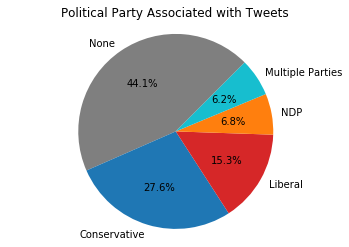

In [11]:
# Create pie chart of party distribution
fig1, ax1 = plt.subplots()
labels = ['None', 'Conservative', 'Liberal', 'NDP', 'Multiple Parties']
colors = ['tab:gray', 'tab:blue', 'tab:red', 'tab:orange', 'tab:cyan']
ax1.pie(partyPercentages, labels = labels , colors = colors, autopct='%1.1f%%', startangle = 45)
ax1.axis('equal')
ax1.set_title('Political Party Associated with Tweets')
plt.show()

To help us get an idea of the words in negative and positive tweets, I created word clouds with the tweets from each category.  I chose to use a word cloud because it is a quick, heuristic way to see which words could have a significant impact to the sentiment of a tweet.  

In [12]:
# Prepare tweets to put into a word cloud
genericNeg = generic.loc[generic['class'] == 0]
genericPos = generic.loc[generic['class'] == 1]
genericNegWords = genericNeg['cleaned_text'].to_numpy()
genericPosWords = genericPos['cleaned_text'].to_numpy()

electionsNeg = elections.loc[elections['sentiment'] == 0]
electionsPos = elections.loc[elections['sentiment'] == 1]
electionsNegWords = electionsNeg['cleaned_text'].to_numpy()
electionsPosWords = electionsPos['cleaned_text'].to_numpy()

Here I print out the emojis associated with negative and positive sentiment for the powerpoint slides.

In [162]:
#print(set(np.hstack(electionsNeg.emojis)))

In [163]:
#print("'🙄', '🚩', '💥', '💪', '🗳', '👉', '🤝', '💩', '👍', '🎵', '🌎', '👽', '🍁', '🙏', '🧐', '👁', '👇', '🤞', '🤓', '🧡', '🧀', '🏴', '😏', '👏', '➡', '🚽', '🍊', '🙃', '💧', '🤦', '🔥', '😂', '🤷', '❤', '📏', '🤣', '⬇', '😠', '🏳', '💦', '🛶', '😋', '🐍', '🤭','😡', '✊', '🍪', '❓', '🤨', '💜', '☹', '😳', '🤮', '🤔', '👿', '🤢', '✈', '🥴', '🤬''💰', '🌈', '♂', '🐭', '😱', '☠', '⬆', '⭐', '🔼', '🤥'")

In [164]:
#print(set(np.hstack(electionsPos.emojis)))

In [165]:
#print("'🏅', '🎃', '🙄', '☕', '📷', '⤵', '🗳', '👉', '🙀', '😍', '🐎', '🤝', '💩', '👍', '🌪', '🤩', '🏃', '✌', '✔', '🍁', '🙏', '👇', '🐧', '🔶', '🤓', '😬', '🙌', '😉', '🧡', '✅', '🚪', '😏', '👏', '😐', '👈', '🤪', '🍊', '🐱', '🤦', '🔵', '😂', '🔥', '📹', '🤷', '❤', '👀', '🤣', '💁', '⬇', '♥', '▶', '🔴', '😃', '😋', '💙', '😨', '😊', '📣', '✊', '🎤', '🍻', '🤨', '😀', '📍', '🙊', '💜', '😳', '🍕', '🤔', '☀', '😭', '🤢', '✈', '🐼', '♂', '😱', '🗣', '⬆', '🍂'")

In [13]:
# Creating word clouds
genericNegWordCloud = WordCloud(background_color = "white").generate(" ".join(genericNegWords))
genericPosWordCloud = WordCloud(background_color = "white").generate(" ".join(genericPosWords))
electionsNegWordCloud = WordCloud(background_color = "white").generate(" ".join(electionsNegWords))
electionsPosWordCloud = WordCloud(background_color = "white").generate(" ".join(electionsPosWords))

Below are the negative and positive word clouds for the generic tweets.  We can quickly see that words like "miss", "work", "want" are heavily associated with negativity while words like "love", "lol", "thank" are associated with positivity.  This is a good sanity check to see the words are cleaned and categorized properly.  You may notice some words like "today" and "think" appear in both word clouds with a similar size.  This means, that these words are most likely neutral and don't have much relevance to the actual sentiment.  Therefore it is a good idea to add these to the stop words list.

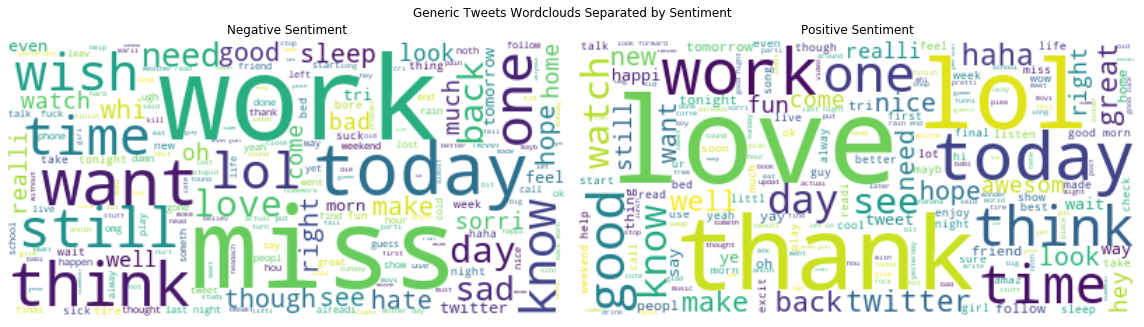

In [14]:
# Plot the generic tweet word clouds
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Generic Tweets Wordclouds Separated by Sentiment')

ax1.imshow(genericNegWordCloud, interpolation = 'bilinear')
ax1.set(title = "Negative Sentiment")
ax1.axis("off")
ax2.imshow(genericPosWordCloud, interpolation = 'bilinear')
ax2.set(title = "Positive Sentiment")
ax2.axis("off")
fig.tight_layout()

Below are the negative and positive word clouds for the election tweets.  We can see words like "lie", and the names of the prime minister candidates "trudeau" and "scheer" are associated with negativity.  This is most likely due to tweets showing displeasure towards the candidates.  On the other hand, words like "canada", and "campaign" are related to positivity.  Once again, there are words common between both categories such as "vote" and "elect" which makes sense since they are neutral in terms of sentiment.  

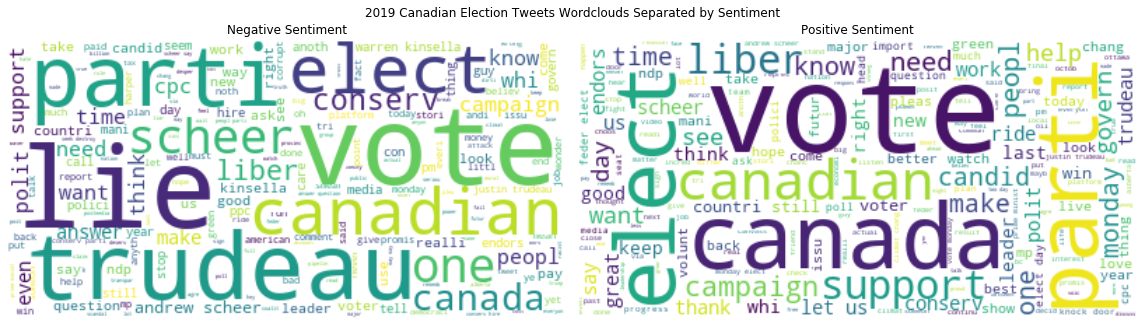

In [15]:
# Plot the election tweets wordclouds
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('2019 Canadian Election Tweets Wordclouds Separated by Sentiment')

ax1.imshow(electionsNegWordCloud, interpolation = 'bilinear')
ax1.set(title = "Negative Sentiment")
ax1.axis("off")
ax2.imshow(electionsPosWordCloud, interpolation = 'bilinear')
ax2.set(title = "Positive Sentiment")
ax2.axis("off")
fig.tight_layout()

(BONUS) I also created word clouds for the hashtags associated with each sentiment category.  We can see that #elxn43 and #cdnpoli are common in both categories which make sense because they only refer to the election in general.  Hashtags like #TrudeauMustGo, #ScheerLies are associated with negativity meanwhile #UpRiSingh, #NDP are associated with positivity.  Clearly, just looking at the hashtag word clouds we can get a sense that there are negative tweets about the Conservatives and Liberals meanwhile more positive tweets about NDP. 

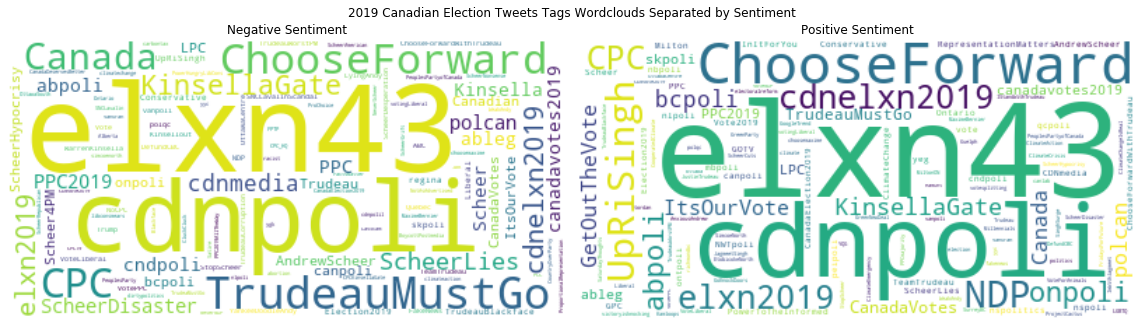

In [16]:
# Create the election hashtags word clouds
electionsPosTags = electionsPos.tags.str.join(" ")
electionsNegTags = electionsNeg.tags.str.join(" ")
electionsNegTagWordCloud = WordCloud(background_color = "white", collocations = False).generate(" ".join(electionsNegTags))
electionsPosTagWordCloud = WordCloud(background_color = "white", collocations = False).generate(" ".join(electionsPosTags))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('2019 Canadian Election Tweets Tags Wordclouds Separated by Sentiment')

ax1.imshow(electionsNegTagWordCloud, interpolation = 'bilinear')
ax1.set(title = "Negative Sentiment")
ax1.axis("off")
ax2.imshow(electionsPosTagWordCloud, interpolation = 'bilinear')
ax2.set(title = "Positive Sentiment")
ax2.axis("off")
fig.tight_layout()

Next, let's look at the balance of the classes in the data.  Taking a look at the balance of the data can help me decide which evaluator to use when testing my machine learning models.  We see the generic tweets are perfectly half negative and half positive meanwhile the election tweets are also very close to be half and half. Therefore, I think it's appropriate to use accuracy score as the model evaluator.  If the dataset was highly unbalanced, I would also check the recall, precision, and F1 score as the accuracy score alone could be misleading.

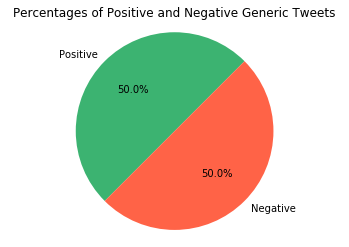

In [17]:
# Create a pie chart of the classes in the generic tweets
genericSentimentTotals = generic['class'].value_counts(normalize = True)

fig1, ax1 = plt.subplots()
labels = ['Positive', 'Negative']
colors = ['mediumseagreen', 'tomato']
ax1.pie(genericSentimentTotals, labels = labels, colors = colors, autopct='%1.1f%%', startangle = 45)
ax1.axis('equal')
ax1.set_title('Percentages of Positive and Negative Generic Tweets')
plt.show()

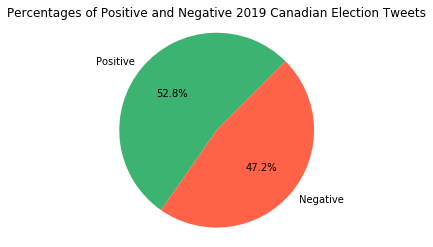

In [18]:
# Create a pie chart of the classes in the election tweets
electionsSentimentTotals = elections['sentiment'].value_counts(normalize = True)

fig1, ax1 = plt.subplots()
labels = ['Positive', 'Negative']
colors = ['mediumseagreen', 'tomato']
ax1.pie(electionsSentimentTotals, labels = labels, colors = colors, autopct='%1.1f%%', startangle = 45)
ax1.axis('equal')
ax1.set_title('Percentages of Positive and Negative 2019 Canadian Election Tweets')
plt.show()

# 3. Model Preparation

Now on to the model preparation stage.  I split the generic tweets to 70% training and 30% testing.  By isolating the test set from model development, we can get a more accurate evaluation of the model. The target labels is binary with each sample being either negative "0" or positive "1" sentiment.

In [19]:
seed = 103

X = generic['cleaned_text']
y = generic['class']
# Split the generic tweet data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

A common way to preprocessing text data for natural language processing is by converting the text to numerical vectors.  Two approaches I used are "bag of words" (ie. word frequency) and TF-IDF.  Bag of words represents every single unique word seen in all the data as a feature and the value is how many times it appears in a given sample.  TF-IDF takes it a step further by also considering how rare a word is across all the samples.  This prevents giving too much weight to words that are just common in all the samples (ie. words similar to stop words). A hyperparameter that needs to be chosen is max_feautres which limits the features to the top n words based on frequency.  I set the limit to 5000 so that the algorithms train in a reasonable amount of time however using more features would theoretically improve model accuracy as long as the models are tuned to not overfit that data.

In [20]:
maxFeats = 5000
# Fit the training data to bag of words (WF) vectorizer
wfv = CountVectorizer(max_features = maxFeats)
_ = wfv.fit(X_train)
# Fit the training data to TF-IDF vectorizer
tfidfv = TfidfVectorizer(use_idf = True, smooth_idf = True, norm = None, max_features = maxFeats)
_ = tfidfv.fit(X_train)

In [21]:
# Transform the train and test data to both WF and TFIDF
X_train_WF = wfv.transform(X_train)
X_train_TFIDF = tfidfv.transform(X_train)
X_test_WF = wfv.transform(X_test)
X_test_TFIDF = tfidfv.transform(X_test)

## 4. Model Implementation

The next step is to set up the models, fit the preprocessed training data, and test it on the test data to obtain an accuracy score.  The alogrithms I used were logistic regression, knn, Naive Bayes, SVM, decision trees, random forests, and XGBoost.  

In [22]:
# Logistic Regression
# Initialize and fit model to WF and TFIDF training data
lr_clf_WF = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train_WF, y_train)
lr_clf_TFIDF = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
lr_pred_WF = lr_clf_WF.predict(X_test_WF)
lr_pred_TFIDF = lr_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
lr_score_WF = accuracy_score(y_test, lr_pred_WF)
lr_score_TFIDF = accuracy_score(y_test, lr_pred_TFIDF)

In [23]:
# KNN
# Initialize and fit model to WF and TFIDF training data
knn_clf_WF = KNeighborsClassifier(n_neighbors = 5).fit(X_train_WF, y_train)
knn_clf_TFIDF = KNeighborsClassifier(n_neighbors = 5).fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
knn_pred_WF = knn_clf_WF.predict(X_test_WF)
knn_pred_TFIDF = knn_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
knn_score_WF = accuracy_score(y_test, knn_pred_WF)
knn_score_TFIDF = accuracy_score(y_test, knn_pred_TFIDF)

In [24]:
# Naive Bayes
# Initialize and fit model to WF and TFIDF training data
nb_clf_WF = MultinomialNB(alpha = 1.0).fit(X_train_WF, y_train)
nb_clf_TFIDF = MultinomialNB(alpha = 1.0).fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
nb_pred_WF = nb_clf_WF.predict(X_test_WF)
nb_pred_TFIDF = nb_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
nb_score_WF = accuracy_score(y_test, nb_pred_WF)
nb_score_TFIDF = accuracy_score(y_test, nb_pred_TFIDF)

In [25]:
# SVM
# Initialize and fit model to WF and TFIDF training data
svm_clf_WF = SVC(kernel = 'rbf', gamma = 'scale', max_iter = 1000, verbose = True).fit(X_train_WF, y_train)
svm_clf_TFIDF = SVC(kernel = 'rbf', gamma = 'scale', max_iter = 1000, verbose = True).fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
svm_pred_WF = svm_clf_WF.predict(X_test_WF)
svm_pred_TFIDF = svm_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
svm_score_WF = accuracy_score(y_test, svm_pred_WF)
svm_score_TFIDF = accuracy_score(y_test, svm_pred_TFIDF)

[LibSVM]

/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


A hyperparameter in tree algorithms is the splitting criterion which determines what is a good split for the nodes.  The two options are 'entropy' and 'gini'.  Entropy maximizes the information gain between the parent and children whereas gini measures the probability a sample is classified incorrectly if it was chosen randomly.  In practice, both criterions yield similar results but I chose to use 'entropy'.

In [26]:
# Decision Trees
# Initialize and fit model to WF and TFIDF training data
dt_clf_WF = DecisionTreeClassifier(criterion = 'entropy', random_state = seed).fit(X_train_WF, y_train)
dt_clf_TFIDF = DecisionTreeClassifier(criterion = 'entropy', random_state = seed).fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
dt_pred_WF = dt_clf_WF.predict(X_test_WF)
dt_pred_TFIDF = dt_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
dt_score_WF = accuracy_score(y_test, dt_pred_WF)
dt_score_TFIDF = accuracy_score(y_test, dt_pred_TFIDF)

In [27]:
# Random Forests
# Initialize and fit model to WF and TFIDF training data
rf_clf_WF = RandomForestClassifier(criterion = 'entropy', n_estimators = 10, random_state = seed).fit(X_train_WF, y_train)
rf_clf_TFIDF = RandomForestClassifier(criterion = 'entropy', n_estimators = 10, random_state = seed).fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
rf_pred_WF = rf_clf_WF.predict(X_test_WF)
rf_pred_TFIDF = rf_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
rf_score_WF = accuracy_score(y_test, rf_pred_WF)
rf_score_TFIDF = accuracy_score(y_test, rf_pred_TFIDF)

In [28]:
# XGBoost
# Initialize and fit model to WF and TFIDF training data
xgb_clf_WF = XGBClassifier().fit(X_train_WF, y_train)
xgb_clf_TFIDF = XGBClassifier().fit(X_train_TFIDF, y_train)

# Get predictions using WF and TFIDF test data
xgb_pred_WF = xgb_clf_WF.predict(X_test_WF)
xgb_pred_TFIDF = xgb_clf_TFIDF.predict(X_test_TFIDF)

# Get accuracy scores for WF and TFIDF test predictions
xgb_score_WF = accuracy_score(y_test, xgb_pred_WF)
xgb_score_TFIDF = accuracy_score(y_test, xgb_pred_TFIDF)

In [29]:
# Put the results into a dataframe for easy comparison
genericResults = pd.DataFrame(
    np.zeros((2,7)),
    columns = ['Logistic Regression', 'KNN', 'Naive Bayes', 'SVM', 'Decision Trees', 'Random Forests', 'XGBoost'],
    index = ['Word Frequency', 'TF-IDF'])

for i in range(genericResults.shape[0]):
    if i == 0:
        scores = [lr_score_WF, knn_score_WF, nb_score_WF, svm_score_WF, dt_score_WF, rf_score_WF, xgb_score_WF]
    else:
        scores = [lr_score_TFIDF, knn_score_TFIDF, nb_score_TFIDF, svm_score_TFIDF, dt_score_TFIDF, rf_score_TFIDF, xgb_score_TFIDF]
   
    for j in range(genericResults.shape[1]):
        genericResults.iat[i,j] = scores[j]

Below is a dataframe that shows the test accuracies using each algorithm with both word frequency and TF-IDF.  Logistic regression using WF obtained the highest test accuracy of 77.3% where SVM with TFIDF obtained the lowest at 53.3%.  All the algorithms performed better using word frequency rather than TF-IDF, notably XGBoost with a 6% performance difference.  

In [30]:
genericResults

,Logistic Regression,KNN,Naive Bayes,SVM,Decision Trees,Random Forests,XGBoost
Word Frequency,0.773667,0.706550,0.764317,0.538467,0.711417,0.751633,0.704967
TF-IDF,0.771133,0.686967,0.754033,0.533100,0.711417,0.751633,0.704967


With XGBoost, it's easy to quickly visualize meaningful feature importances.  We can see words like "thank", "sad", "love", "hate" have high importance as expected from observing the word clouds.

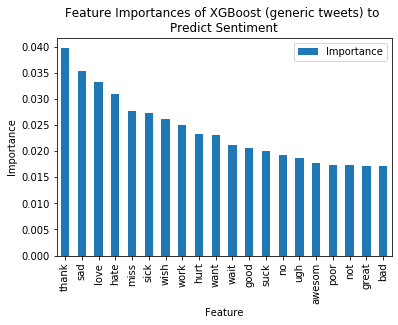

In [144]:
# Plot the feature importances of XGBoost
xgb_fi = xgb_clf_WF.feature_importances_
xgb_fi_feats = np.array(wfv.get_feature_names())
fm = np.vstack((xgb_fi_feats, xgb_fi)).T
fi_df = pd.DataFrame(fm, columns = ['Feature', 'Importance'])
fi_df.Importance = fi_df.Importance.astype(np.float64)
fi_df = fi_df.sort_values(by = 'Importance', ascending = False)

ax = fi_df.head(20).plot.bar(x = 'Feature', y = 'Importance', title = "Feature Importances of XGBoost (generic tweets) to \nPredict Sentiment")
_ = ax.set_ylabel("Importance")

Now I'll use my highest performing model (Logisitc Regression with WF) on the election tweets. Comparing the predicted sentiment to the true sentiments, the accuracy was 64%.  It makes sense that the accuracy is lower compared to testing with the generic tweets because only 47% of the words found in the elections tweets is in the generic tweets model.

In [31]:
X_e = elections['cleaned_text']
X_e = wfv.transform(X_e) # Transform tweets using the same word frequency vectorizer
y_e = elections['sentiment']

lr_pred_WF_e = lr_clf_WF.predict(X_e) # Predict results using the same linear regression model
lr_score_WF_e = accuracy_score(y_e, lr_pred_WF_e) # Obtain an accuracy score

In [32]:
# Check how many words in the election tweets are found in the generic tweets model
wfvelections = CountVectorizer()
_ = wfvelections.fit(elections['cleaned_text'])
sameWords = len(list(set(wfv.get_feature_names()).intersection(set(wfvelections.get_feature_names()))))
print(sameWords, "(", '{:,.0%}'.format(sameWords/maxFeats), ") of 5000 words in the generic tweets model were found in the election tweets")

2338 ( 47% ) of 5000 words in the generic tweets model were found in the election tweets


In [33]:
elections['sentiment_predicted'] = lr_pred_WF_e # Add sentiment predictions to elections dataframe
elections_parties_only = elections[~elections["party"].isin(["Multiple Parties", "None"])] # Drop rows associated with multiple parties and no parties

# Create a pivot table obtain the count of each class grouped by the 3 parties 
true_sent_results = pd.pivot_table(elections_parties_only, values = 'text', index = ['party'], columns = ['sentiment'], aggfunc = 'count')
true_sent_results = true_sent_results.div(true_sent_results.sum(axis = 1), axis = 0) # Normalize counts

# Create a pivot table obtain the count of each class grouped by the 3 predicted parties 
pred_sent_results = pd.pivot_table(elections_parties_only, values = 'text', index = ['party'], columns = ['sentiment_predicted'], aggfunc = 'count')
pred_sent_results = pred_sent_results.div(pred_sent_results.sum(axis = 1), axis = 0) # Normalize counts

In [34]:
print("The accuracy of predicted sentiment is: " '{:,.1%}'.format(lr_score_WF_e))

The accuracy of predicted sentiment is: 64.0%


First let's visualize the true sentiments of the 3 parties.  We can see about 70% if tweets about Conservative are negative, about half the tweets about Liberal are negative, and about 70% of tweets about NDP are positive.  This means a lot of people have negative sentiment towards both Conservatives and Liberals but MORE people have negative sentiment towards Conservative.  Meanwhile, most people have a positive sentiment towards NDP.

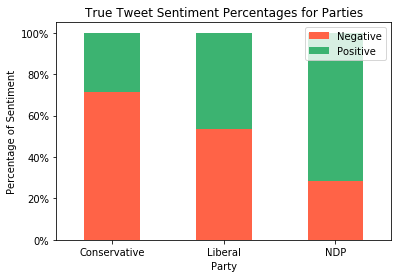

In [35]:
colours = ['tomato', 'mediumseagreen']
ax1 = true_sent_results.plot.bar(stacked = True, color = colours)
vals = ax1.get_yticks()
_ = ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
_ = ax1.set_ylabel("Percentage of Sentiment")
_ = ax1.set_xlabel("Party")
_ = ax1.legend(("Negative", "Positive"))
_ = ax1.set_title("True Tweet Sentiment Percentages for Parties")
_ = plt.xticks(rotation = 0)

Now let's visualize the predicted sentiments of the 3 parties.  We can see the model predicted more tweets to be positive when they are negative.  The predictions show that all 3 parties have more positive tweets than negative, which is not the truth for Conservative and Liberal.  However, it managed to predict the relative amount negative sentiment.  We can still see Conservative has the highest percentage of negative tweets, followed by Liberal, and NDP.  

Based soley on the prior knowledge of the 2015 federal election with Liberals having 39.5% of votes, Conservatives having 31.9% of votes, and NDP having 19.7% of votes, I will naively assume the 2019 federal election would result in either Liberals or Conservatives winning.  Taking a look at the predicted sentiments of tweets, we can see there is 4% more negative sentiment towards Conservative than Liberal.  Based on this, we can predict that Liberals will win the election but not by a large margin which is exactly the real election outcome with Liberals having 33.1% votes/157 seats, and Conservatives having 34.4% votes/121 seats.

Therefore, NLP analytics appear to be useful for political parties to monitor during election campagins.  If there is greater negative sentiment percentage compared to other parties, it is an indication that they may lose the election.  It would be beneficial for data scientists working in political parties to analyze the tweets with negative predicted sentiments to extract information about the public's negative opinions on the party.  This valuable information can then be used to support the public relations department to produce advertisements to attempt to change the public's opinion. 

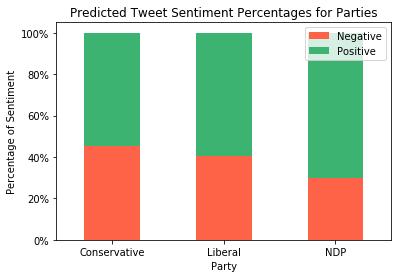

In [36]:
colours = ['tomato', 'mediumseagreen']
ax2 = pred_sent_results.plot.bar(stacked = True, color = colours)
vals2 = ax2.get_yticks()
_ = ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
_ = ax2.set_ylabel("Percentage of Sentiment")
_ = ax2.set_xlabel("Party")
_ = ax2.legend(("Negative", "Positive"))
_ = ax2.set_title("Predicted Tweet Sentiment Percentages for Parties")
_ = plt.xticks(rotation = 0)

Building on the last point, we can classify the negative tweets into categories so the political party can know which issue to focus on in their PR.  In the election data, there are 10 categories but I dropped the "Other" category since it was highly imbalanced and provides little information.  I also absorbed the "Healthcare" category into "Healthcare and Marijuana" since they are related.  In the end, I have 8 categories.

In [37]:
X_neg = elections[elections["sentiment"] == 0]
X_neg = X_neg[X_neg['negative_reason'] != 'Others'] # Drop "Other" reason rows
X_neg.loc[X_neg['negative_reason'] == "Healthcare", 'negative_reason'] = "Healthcare and Marijuana" # Include "Healthcare" in "Healthcare and Marijuana" class
y_neg = X_neg['negative_reason']

Taking a look at the value counts for each category, we can see the data is highly imbalanced with most negative tweets belonging to the "Scandal" or "Tell lies" categories.  Therefore to evaluate the model, I will look at the precision, recall, and f1 score in addition to the accuracy.

In [38]:
neg_value_counts = y_neg.value_counts()
print(neg_value_counts)
numClasses = len(y_neg.value_counts().tolist())

Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare and Marijuana                 9
Name: negative_reason, dtype: int64


Here I encode the labels into numbers.  The one hot encoding of the categorical labels is handled in the models. I split the negative tweets data into 70% training and 30% testing.

In [39]:
# Encode the categorical labels to numbers
le = LabelEncoder()
le.fit(y_neg.to_numpy())
y_neg = le.transform(y_neg)

# Split the data to train and test
X_train_neg, X_test_neg1, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size = 0.3, random_state = seed)


X_train_neg = X_train_neg['cleaned_text']
X_test_neg = X_test_neg1['cleaned_text']

# Transform the test labels back into categories since they are not used in the modelling process
y_test_neg = le.inverse_transform(y_test_neg)

I will use the TFIDF vectorizing method with logisitic regression, random forests, and XGBoost algorithms.

In [40]:
maxFeats = 5000

# TFIDF vectorize the training data
tfidfv2 = TfidfVectorizer(use_idf = True, smooth_idf = True, norm = None, max_features = maxFeats)
_ = tfidfv2.fit(X_train_neg)

In [41]:
# Fit the train data to vectorizer
X_train_neg = tfidfv2.transform(X_train_neg)

# Fit the test data to vectorizer
X_test_neg = tfidfv2.transform(X_test_neg)

For logisitic regression, I use the one-vs-method which predicts the class with the highest probability since the categories are not ordinal.

In [42]:
# Logistic regression
lr_clf_neg = LogisticRegression(random_state = seed, solver = 'liblinear', multi_class = 'ovr').fit(X_train_neg, y_train_neg)

# Predict values and transform back to categorical label
lr_pred_neg = lr_clf_neg.predict(X_test_neg)
lr_pred_neg = le.inverse_transform(lr_pred_neg)

print(classification_report(y_test_neg, lr_pred_neg))

                                     precision    recall  f1-score   support

                    Climate Problem       1.00      0.62      0.76        13
                            Economy       0.90      0.47      0.62        19
           Healthcare and Marijuana       0.00      0.00      0.00         2
                          Privilege       0.00      0.00      0.00         3
                            Scandal       0.65      0.79      0.71        85
                         Separation       0.00      0.00      0.00         4
                          Tell lies       0.53      0.64      0.58        53
Women Reproductive right and Racism       0.83      0.36      0.50        14

                           accuracy                           0.64       193
                          macro avg       0.49      0.36      0.40       193
                       weighted avg       0.65      0.64      0.62       193



/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
# Random forests
rf_clf_neg = RandomForestClassifier(criterion = 'entropy', n_estimators = 10, random_state = seed).fit(X_train_neg, y_train_neg)

# Predict values and transform back to categorical label
rf_pred_neg = rf_clf_neg.predict(X_test_neg)
rf_pred_neg = le.inverse_transform(rf_pred_neg)

print(classification_report(y_test_neg, rf_pred_neg))

                                     precision    recall  f1-score   support

                    Climate Problem       0.70      0.54      0.61        13
                            Economy       0.67      0.21      0.32        19
           Healthcare and Marijuana       0.00      0.00      0.00         2
                          Privilege       0.00      0.00      0.00         3
                            Scandal       0.61      0.74      0.67        85
                         Separation       0.00      0.00      0.00         4
                          Tell lies       0.47      0.60      0.53        53
Women Reproductive right and Racism       1.00      0.43      0.60        14

                           accuracy                           0.58       193
                          macro avg       0.43      0.32      0.34       193
                       weighted avg       0.58      0.58      0.56       193



/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [168]:
# XGBoost
xgb_clf_neg = XGBClassifier()
xgb_clf_neg.fit(X_train_neg, y_train_neg)

# Predict values and transform back to categorical label
xgb_pred_neg = xgb_clf_neg.predict(X_test_neg)
xgb_pred_neg = le.inverse_transform(xgb_pred_neg)

print(classification_report(y_test_neg, xgb_pred_neg))

                                     precision    recall  f1-score   support

                    Climate Problem       0.90      0.69      0.78        13
                            Economy       0.78      0.37      0.50        19
           Healthcare and Marijuana       0.00      0.00      0.00         2
                          Privilege       0.00      0.00      0.00         3
                            Scandal       0.64      0.86      0.73        85
                         Separation       0.67      0.50      0.57         4
                          Tell lies       0.65      0.60      0.63        53
Women Reproductive right and Racism       0.88      0.50      0.64        14

                           accuracy                           0.67       193
                          macro avg       0.56      0.44      0.48       193
                       weighted avg       0.68      0.67      0.66       193



/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
print("Logisitic regression F1 score: ", f1_score(y_test_neg, lr_pred_neg, average = 'micro'))
print("Random forests F1 score: ", f1_score(y_test_neg, rf_pred_neg, average = 'micro'))
print("XGBoost F1 score: ", f1_score(y_test_neg, xgb_pred_neg, average = 'micro'))

Logisitic regression F1 score:  0.6373056994818653
Random forests F1 score:  0.5803108808290155
XGBoost F1 score:  0.6735751295336787


The highest performing model in predicting the negative sentiment reason is XGBoost with an F1 score of 67%.

(BONUS) I will perform hyperparameter tuning on the XGBoost model.  The tuning results show that the parameter max_depth of 6 is already the optimal based on the cross validation f1_micro scores so no changes were made to the model.

In [173]:
parameters = {'max_depth': (4,5,6,7)}
gs = GridSearchCV(xgb_clf_neg, parameters, cv = 2, scoring = 'f1_micro', return_train_score = True)
gs.fit(X_train_neg, y_train_neg)

/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None, param_grid={'max_depth': (4, 5, 6, 7)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1_micro', verbose=0)

In [174]:
gsResults = pd.DataFrame.from_dict(gs.cv_results_)
gsResults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,8.431512,0.120494,0.011748,0.000350,4,{'max_depth': 4},0.550661,0.594595,0.572383,0.021966,3,0.941441,0.925110,0.933276,0.008166
1,9.651304,0.135745,0.013451,0.000818,5,{'max_depth': 5},0.541850,0.608108,0.574610,0.033127,2,0.968468,0.964758,0.966613,0.001855
2,10.978449,0.417152,0.013910,0.000320,6,{'max_depth': 6},0.563877,0.612613,0.587973,0.024366,1,0.972973,0.977974,0.975473,0.002500
3,12.570968,0.710255,0.016771,0.001355,7,{'max_depth': 7},0.559471,0.572072,0.565702,0.006300,4,0.981982,0.982379,0.982180,0.000198


Once again, I plot the feature importances of XGBoost.  We can see words corresponding to the negative reasons are are ranked highest:

lie -> Tell lies <br>
abort -> Women Reproductive Right and Racism<br>
climat -> Climate Problem<br>
racism -> Women Reproductive Right and Racism

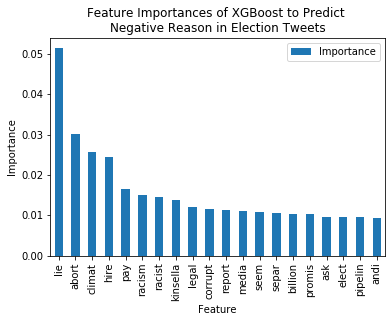

In [142]:
# Plot the feature importances of XGBoost
xgb_fi = xgb_clf_neg.feature_importances_
xgb_fi_feats = np.array(tfidfv2.get_feature_names())
fm = np.vstack((xgb_fi_feats, xgb_fi)).T
fi_df = pd.DataFrame(fm, columns = ['Feature', 'Importance'])
fi_df.Importance = fi_df.Importance.astype(np.float64)
fi_df = fi_df.sort_values(by = 'Importance', ascending = False)

ax = fi_df.head(20).plot.bar(x = 'Feature', y = 'Importance', title = "Feature Importances of XGBoost to Predict \nNegative Reason in Election Tweets")
_ = ax.set_ylabel("Importance")

## 5. Results

Now to answer the research question: "What can public opinion on Twitter tell us about the Canadian political landscape in 2019?"

The logistic regression model using word frequency trained on 140000 generic tweets obtained a 64% accuracy score when predicting the sentiment of the 2133, 2019 Canadian election tweets.  The model predicted 45%, 41%, and 30% negative tweets for Conservative, Liberal, and NDP respectively.  The true values are 71%, 54%, 29% respectively. 

But let's only discuss the predicted sentiment results.  The results show that public opinion is more positive about NDP than Conservative and Liberal since it has 15% and 11% lower percentage of negative sentiment respectively.  Conservatives have the highest percentage (45%) of negative tweets, meaning that the public feels most negatively about that party.  However, Liberal is also very close with 41% of negative tweets.  If we naively ignore all other factors and predict the election outcome based solely on twitter sentiment analysis, then NDP would be predicted to be elected.  However there are many other political factors to consider.  As described above in the Model Implementation section, we can consider historical federal political election results.  If we have a prior probablisitc prediction that either Conservative and Liberal would be elected, we can predict that Liberal would be elected since it has 4% less negative tweets.  But, it does still have 41% of negative tweets.  This indicates that there is still a significant negative opinion on the Liberals and suggest they will not win by a majority.  This aligns with the true 2019 Canadian election results with Justin Trudeau being elected with Liberal as a minority government.  

Now let's dicuss the prediction of the negative reasons.  The best performing model was XGBoost with F1 score of 67% which was trained on 449 samples and tested on 193 samples.  To see where the model made mistakes, I use a confusion matrix which shows which true categories were predicted to which wrong categories.  We can see that the model made the most mistakes by classifiying 21 "Tell lies" as "Scandal" and 8 "Scandals" as "Tell lies". Let's focus on the examples that predicted "Tell lies" as "Scandal".

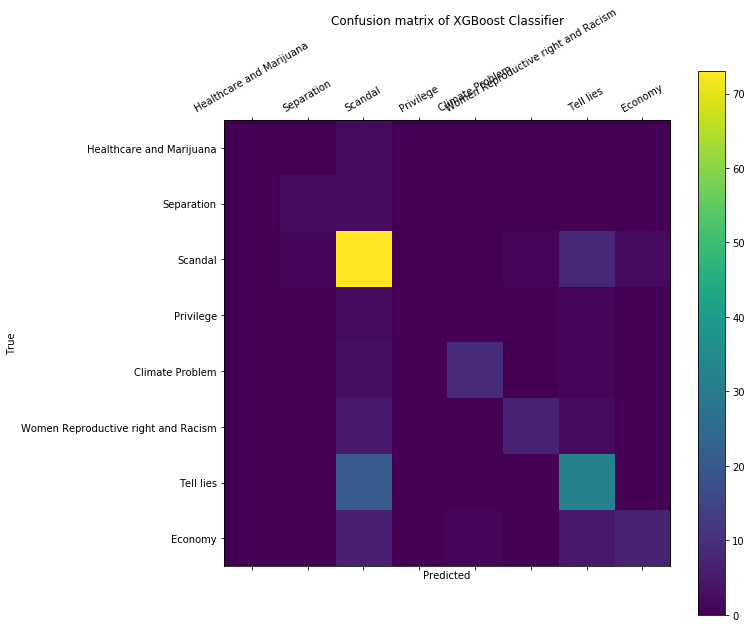

[[ 0  0  2  0  0  0  0  0]
 [ 0  2  2  0  0  0  0  0]
 [ 0  1 73  0  0  1  8  2]
 [ 0  0  2  0  0  0  1  0]
 [ 0  0  3  0  9  0  1  0]
 [ 0  0  5  0  0  7  2  0]
 [ 0  0 21  0  0  0 32  0]
 [ 0  0  6  0  1  0  5  7]]


In [46]:
# Plotting confusion matrix
labels = list(set(y_test_neg))
cm = confusion_matrix(y_test_neg, xgb_pred_neg, labels = labels)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of XGBoost Classifier', y = 1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels, rotation = 30)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)

This is understandable since a scandal is related to telling lies.  The model could have picked up words in the Scandal tweets which also appear in the Tell lies tweets.  An example of this is sample 163: 

_"@spencerbennett1 @CBCKatie He was asked 23 times because he didn't answer\n\nShe can't talk policy because they delayed the program til the night before the ballot. Blame #CPC for that.\n\nAnd, if you can't see how hiring __liars__ can affect your political system, don't ask.\n\n#cdnelxn2019 #elxn43 #CBC #Scheerlies"_

The model could have easily classified this tweet as a Tell lies because it contains the word __liar__

Another example is sample 88:

_"@JaroGiesbrecht @JustinTrudeau Well.... Warren Kinsella has been all over Twitter promoting Andrew Scheer's FAKE __SCANDALS__.... So yes it sure looks like Andrew Scheer hired Warren Kinsella to smear Justin Trudeau as well!\n\n#cdnpoli #elxn43"_

It even contains the word SCANDALS -> scandal (stem) which is quite misleading for the algorithm since it is really a "Tell lies".

This demonstrates the challenges of natural language processing because the algorithm does not have true semantic interpretability capabilities.

Another reason for the misclassification is because there are more Scandal (85) training examples than Tell lies (53).  With more training examples, the model would have more information to distingush between the two categories.


In [47]:
X_test_negatives = X_test_neg1.copy()
X_test_negatives['predicted_negative_reason'] = xgb_pred_neg

In [48]:
# Show samples where "Tell lies" were misclassified as "Scandal"
pd.set_option('display.max_colwidth', -1)
X_test_negatives_wrong = X_test_negatives[X_test_negatives['negative_reason'] != X_test_negatives['predicted_negative_reason']]
X_test_negatives_wrong = X_test_negatives_wrong[['negative_reason', 'predicted_negative_reason', 'text', 'cleaned_text']]
X_test_negatives_wrong[(X_test_negatives_wrong['predicted_negative_reason'] == "Scandal") & (X_test_negatives_wrong['negative_reason'] == "Tell lies")]

,negative_reason,predicted_negative_reason,text,cleaned_text
2057,Tell lies,Scandal,b'When even your supporters question your honesty and integrity. #elxn43 #cdnelxn2019 https://t.co/HIB1YxxBL0',even support question honesti integr
1206,Tell lies,Scandal,"b'Anyways. \n\nDon\xe2\x80\x99t believe the trolls &amp; their dirty, filthy mouths. \n\nGet out &amp; vote. \n\n#elxn43 #ChooseForward https://t.co/HHJANsMo48'",anyway not believ troll dirti filthi mouth get vote
163,Tell lies,Scandal,"b""@spencerbennett1 @CBCKatie He was asked 23 times because he didn't answer\n\nShe can't talk policy because they delayed the program til the night before the ballot. Blame #CPC for that.\n\nAnd, if you can't see how hiring liars can affect your political system, don't ask.\n\n#cdnelxn2019 #elxn43 #CBC #Scheerlies""",ask time not answer not talk polici delay program til night ballot blame not see how hire liar affect polit system not ask
744,Tell lies,Scandal,b'@CelMarJH He just loves his costumes so much-\n\nOh...and his canoes\xf0\x9f\x9b\xb6\xf0\x9f\x9b\xb6\xf0\x9f\x9b\xb6\xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f\xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f\xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f\n\n#TrudeauWorstPM #Scheer4PM \n#SCHEER4THEWIN #AttackCanoes \n#elxn43 #cdnelxn2019 \xf0\x9f\x87\xa8\xf0\x9f\x87\xa6\xf0\x9f\x8d\x81\xf0\x9f\x87\xa8\xf0\x9f\x87\xa6 https://t.co/vSfXTZxNGA',love costum much oh cano
172,Tell lies,Scandal,"b""@theJagmeetSingh has bashed @JustinTrudeau through the entire campaign and yet is willing to help him form government? His intentions are the same as Mr.Trudeau... what's best for me? If he had any integrity he wouldn't have brought this up to begin with! #elxn43 #CPC #cdnpoli""",bash entir campaign yet will help form govern intent mr trudeau best integr would not brought begin
49,Tell lies,Scandal,"b""@CandiceMalcolm @HeshmatAlavi he's a well-known rafidite-supporting jerk and nothing is done about it. Trudeau is a hypocrite - he brings in Syrian refugees fleeing from Iran's bombs and runs an Iranian regime supporter as an MP. #elxn43 #cdnpoli #TrudeauMustGo #TrudeauHypocrite""",well known rafidit support jerk noth done trudeau hypocrit bring syrian refuge flee iran bomb run iranian regim support mp
88,Tell lies,Scandal,"b""@JaroGiesbrecht @JustinTrudeau Well.... Warren Kinsella has been all over Twitter promoting Andrew Scheer's FAKE SCANDALS.... So yes it sure looks like Andrew Scheer hired Warren Kinsella to smear Justin Trudeau as well!\n\n#cdnpoli #elxn43""",well warren kinsella twitter promot andrew scheer fake scandal ye sure look like andrew scheer hire warren kinsella smear justin trudeau well
1917,Tell lies,Scandal,"b'This is outrageous! The #ScheerLies are never ending #Canada! \n\n\xe2\x80\x9cHe\'s doing damage because\xc2\xa0there\'s so many Canadians who will believe what he says to be true.""~Professor Peter Russell \n\nhttps://t.co/JVeRXcC3ny\xe2\x80\xa6 #Cdnpoli\xc2\xa0 #elxn43\xc2\xa0 #CPC-Lies, period. #LPC #NDP #GreenParty #Onpoli'",outrag never end damag mani canadian believ say true professor peter russel period
923,Tell lies,Scandal,"b'@MikeMcPickles @Frazzling @AndrewScheer @CPC_HQ Yeah - as soon as they get power the slogan suddenly always changes to ""Stand on your own damn feet."" #CPC #cdnpoli #elxn43'",yeah soon get power slogan suddenli alway chang stand damn feet
749,Tell lies,Scandal,b'@charliesmithvcr @wengcouver @globalnews @NDP @liberal_party @CBCNews @CPC_HQ @AndrewScheer @peoplespca @niknanos @CanadianGreens @BlocQuebecois @JustinaCPC @CBCKatie @KatieCBC @JPTasker @DouglasTodd @JustinTrudeau @theJagmeetSingh @ElizabethMay @HedyFry @VancouverSun @nickeagland @CTVNews @globeandmail @TorontoStar @CKNW @ubcprez @NatashaFatah @reshminair @VassyKapelos @CochraneCBC @HannahThibedeau @aartipole @BashirMohamed @andraydomise @fatimabsyed @RitikaGoelTO @althiaraj @JennyKwanBC @Taleeb @Puglaas #giveusdata #cdnpoli #bcpoli #vanpoli #YVRRE #vanre\n@charliesm

In [49]:
pd.set_option('display.max_colwidth', 50)

Here are some ways to improve the accuracy of both models:

1. Use lemmetization instead of stemming to get better semantic representations of words.
2. Try n-grams instead of tokenizing strings on just one word.
3. Try word embeddings
4. Tune the hyperparameters of the models, such as max depth in XGBoost.  In addition, tune based on the 
   bias variance tradeoff.